# Hotel Booking Demand

## By: John Rooney, Michael Sebring, and Jonathan Lynch

__Data set description:__

This data set contains booking information from two different hotels, a resort hotel and a city hotel located in Portugal. The resort hotel is located in the region of Algarve and the city hotel is located in the city of Lisbon. The data includes information such as when the booking was made, the length of stay, the number of adults, children, and/or babies, the number of available parking spaces, customer type, whether the booking was cancelled, guest country of origin, average daily rate, etc.  All of the bookings were due to arrive between July 1, 2015 and August 31, 2017.  The data set can be obtained at: https://www.kaggle.com/jessemostipak/hotel-booking-demand#

__Import libraries and read in file:__

In [133]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors, tree, naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, r2_score, roc_auc_score, plot_roc_curve, mean_absolute_error
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pyplt

In [134]:
#%cd "/Users/jonathanlynch/Desktop/DSC 478"

pd.set_option('display.max_columns', None)   # change view to see all attributes
data = pd.read_csv("hotel_bookings.csv")

data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [135]:
data.shape  # look at size of dataset

(119390, 32)

## Clean Data:

__Take a look at the data types:__

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

At first glance, it appears that there are 12 categorical variables.  However, the variables is_canceled, is_repeated_guest, and agent (represented by travel agency ID) are really categorical in nature but are already represented as numbers. The last column, reservation_status_date, is an ordinal attribute, but in most cases is identical to the arrival date.

__Check for missing values:__

In [137]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [138]:
data.describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,119390,119390.000000,119390.000000,119390.000000,119390,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390,118902,119390,119390,119390.000000,119390.000000,119390.000000,119390,119390,119390.000000,119390,103050.000000,6797.000000,119390.000000,119390,119390.000000,119390.000000,119390.000000,119390,119390
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,177,8,5,NaN,NaN,NaN,10,12,NaN,3,NaN,NaN,NaN,4,NaN,NaN,NaN,3,926
top,City Hotel,NaN,NaN,NaN,August,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,Online TA,TA/TO,NaN,NaN,NaN,A,A,NaN,No Deposit,NaN,NaN,NaN,Transient,NaN,NaN,NaN,Check-Out,2015-10-21
freq,79330,NaN,NaN,NaN,13877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92310,48590,56477,97870,NaN,NaN,NaN,85994,74053,NaN,104641,NaN,NaN,NaN,89613,NaN,NaN,NaN,75166,1461
mean,NaN,0.370416,104.011416,2016.156554,NaN,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,NaN,NaN,NaN,NaN,0.031912,0.087118,0.137097,NaN,NaN,0.221124,NaN,86.693382,189.266735,2.321149,NaN,101.831122,0.062518,0.571363,NaN,NaN
std,NaN,0.482918,106.863097,0.707476,NaN,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,NaN,NaN,NaN,NaN,0.175767,0.844336,1.497437,NaN,NaN,0.652306,NaN,110.774548,131.655015,17.594721,NaN,50.535790,0.245291,0.792798,NaN,NaN
min,NaN,0.000000,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,6.000000,0.000000,NaN,-6.380000,0.000000,0.000000,NaN,NaN
25%,NaN,0.000000,18.000000,2016.000000,NaN,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,9.000000,62.000000,0.000000,NaN,69.290000,0.000000,0.000000,NaN,NaN
50%,NaN,0.000000,69.000000,2016.000000,NaN,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,14.000000,179.000000,0.000000,NaN,94.575000,0.000000,0.000000,NaN,NaN
75%,NaN,1.000000,160.000000,2017.000000,NaN,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,229.000000,270.000000,0.000000,NaN,126.000000,0.000000,1.000000,NaN,NaN


__Drop unnecessary variables:__ 

In [139]:
data.drop(columns=['company', 'reservation_status_date'], inplace=True)
#data = data.drop('company', 1)    # drop company variable (94% of items missing for this column)
#data = data.drop('reservation_status_date', 1)   # drop reservation_status_date (essentially the same as arrival date)

__Replace missing values:__

In [140]:
# for missing children values, assume zero children
# for missing country, replace with "Unknown"
# if travel agency is missing, replace with zero (customer most likely did not use a booking agent)
# if is company missing, replace with zero (most likely was private)

null_replacements = {"children": 0.0, "country": "Unknown", "agent": 0}

data = data.fillna(null_replacements)

__Replace all meal values listed as 'Undefined' with 'SC':__

In [141]:
data['meal'].replace('Undefined', 'SC', inplace=True)  # dataset detail mentions these are the same

__Drop rows that have values of 0 adults, 0 children, and 0 babies listed (no guests):__

In [142]:
# some rows have zero guests listed: drop these observations

no_guests = list(data.loc[data['adults']
                   + data['children']
                   + data['babies']==0].index)

data.drop(data.index[no_guests], inplace=True)

In [143]:
data.shape   # see how many rows were removed

(119210, 30)

## Explore Data (EDA):

__Separate by variable type:__

In [144]:
#categorical vars
cats = ['agent', 'arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_week_number', 'arrival_date_month', 'is_repeated_guest', 'distribution_channel', 'is_canceled', 'hotel', 'meal', 'country', 'market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']
#continuous vars
cont = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

### Continuous Variables

__Histograms showing distribution of continuous variables:__

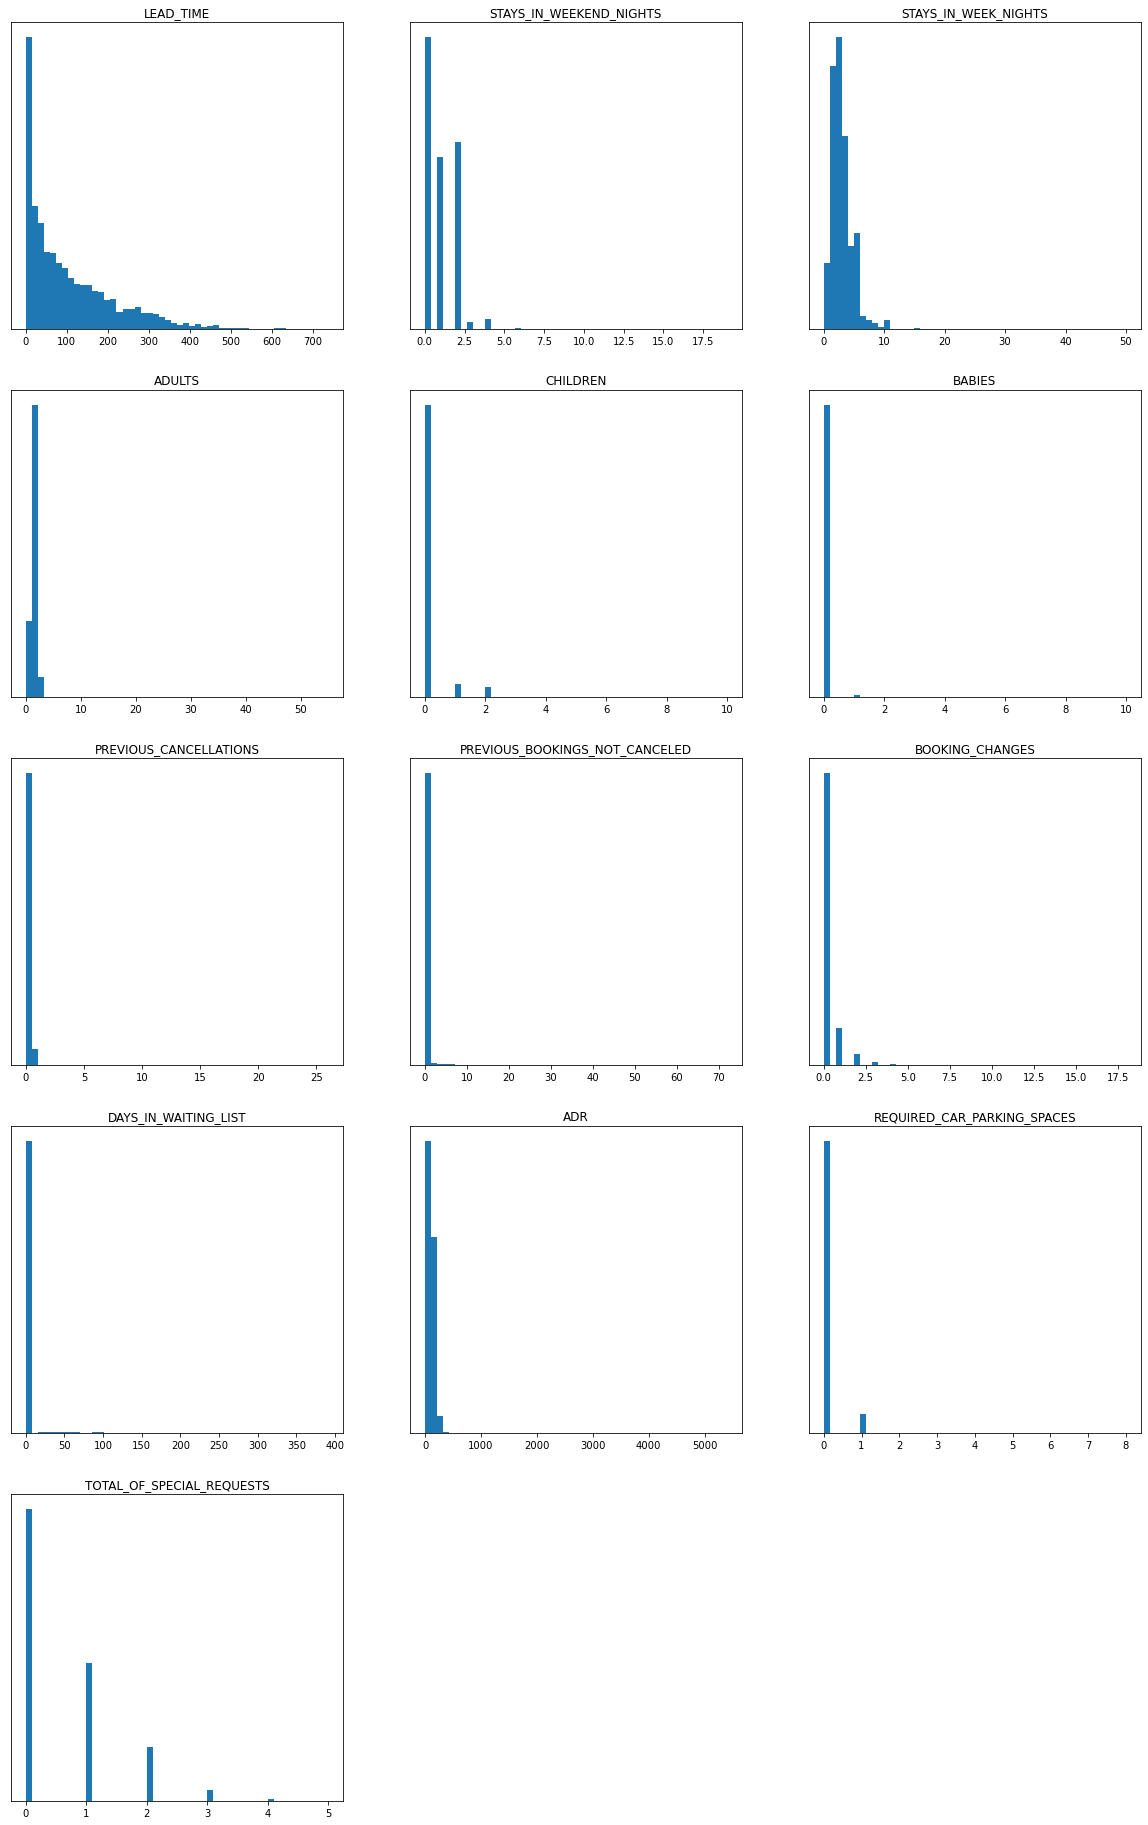

In [13]:
fig, ax = plt.subplots(figsize=(16, 25))
ax.axis('off')
fig.tight_layout()
for idx, i in enumerate(cont):
    fig.add_subplot(5,3,idx+1)
    plt.hist(data[i], bins = 50)
    plt.yticks([])
    plt.title(i.upper())

We can see from the histograms above that most of our continuous variables are highly skewed to the right. We will have to attempt to normalize these.

__Drop outlier:__

In [146]:
data[data['adr']>5000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12.0,0,Transient,5400.0,0,0,Canceled


In [147]:
data.drop([48515], axis=0, inplace=True) # drop single row with adr > 5000 b/c it is an outlier

### Show Relationship b/w ADR and Continuous Variables

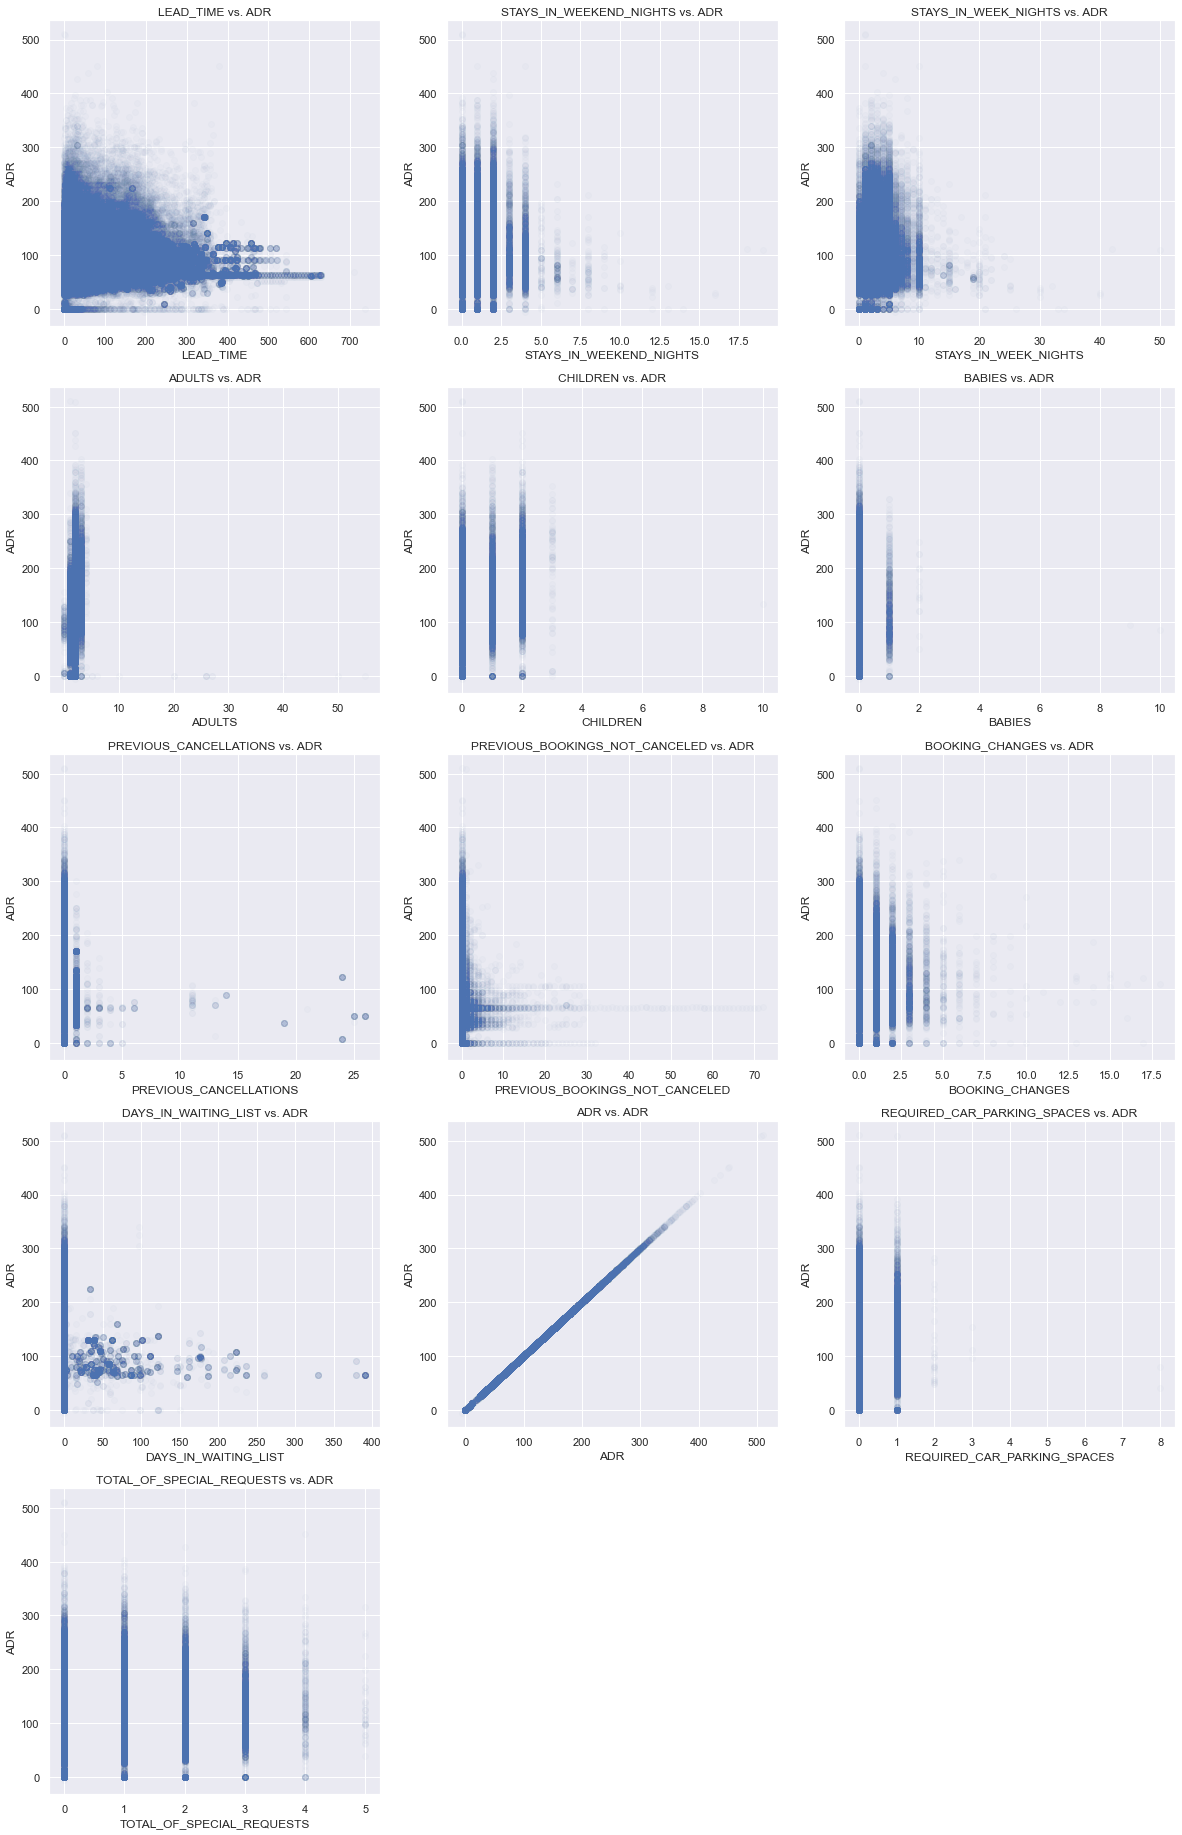

In [152]:
fig, ax = plt.subplots(figsize=(16, 25))
ax.axis('off')
fig.tight_layout()
for idx, i in enumerate(cont):
    fig.add_subplot(5,3,idx+1)
    plt.scatter(data[i], data['adr'], alpha=0.02)
    plt.ylabel('ADR')
    plt.xlabel(i.upper())
    plt.title('{} vs. ADR'.format(i.upper()))

#### Showing Percentage of top 5 most common values in continuous variables:


In [14]:
for i in cont:
    print(i.upper())
    print(data[i].value_counts(normalize=True)[:5]*100)
    print()

LEAD_TIME
0    5.254593
1    2.889858
2    1.732237
3    1.522523
4    1.434443
Name: lead_time, dtype: float64

STAYS_IN_WEEKEND_NIGHTS
0    43.532422
2    27.905377
1    25.681570
4     1.549367
3     1.050247
Name: stays_in_weekend_nights, dtype: float64

STAYS_IN_WEEK_NIGHTS
2    28.244275
1    25.410620
3    18.656992
5     9.284456
4     8.005201
Name: stays_in_week_nights, dtype: float64

ADULTS
2    75.228588
1    19.316333
3     5.202584
0     0.187065
4     0.052009
Name: adults, dtype: float64

CHILDREN
0.0    92.794229
1.0     4.077678
2.0     3.063501
3.0     0.063753
Name: children, dtype: float64

BABIES
0     99.230769
1      0.754970
2      0.012583
10     0.000839
9      0.000839
Name: babies, dtype: float64

PREVIOUS_CANCELLATIONS
0     94.565053
1      5.073400
2      0.095630
3      0.054526
24     0.040265
Name: previous_cancellations, dtype: float64

PREVIOUS_BOOKINGS_NOT_CANCELED
0    96.969214
1     1.290160
2     0.486536
3     0.279339
4     0.192098
Name: pr

Children, babies, previous_cancelations, previous_bookings_not_cancelled, days_in_waiting_list, required_parking_spaces all have >90% of instances in most common value (babies > 99%). Should consider which are useful.

### Correlation heat map for continuous variables:

<AxesSubplot:>

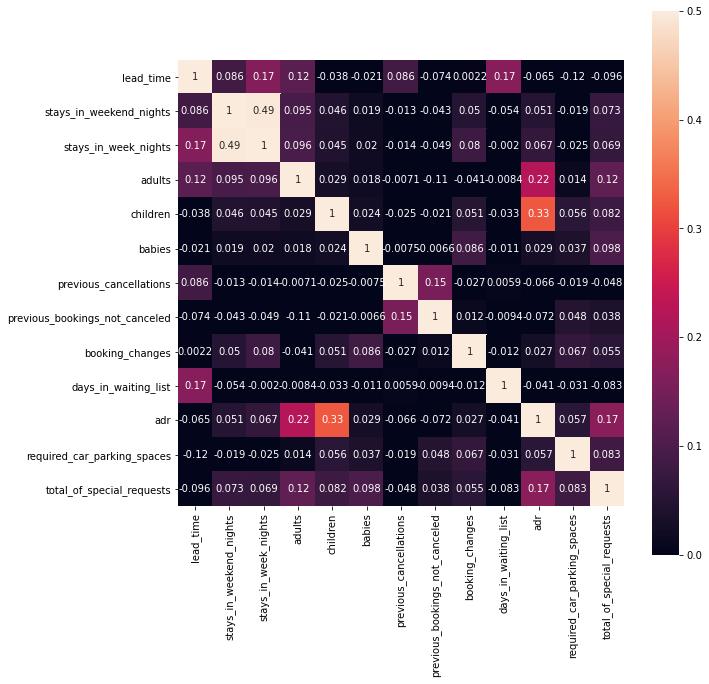

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data[cont].corr(), annot=True, square=True, vmin=0, vmax=0.5)

- Highest correlation is 0.49
- Few variable pairs have correlation above 0.1

### Print variable pairs with correlation values over threshold:

In [16]:
corr = data[cont].corr()
high = []
thresh = 0.1 # threshhold
for i in range(corr.shape[0]):
    for a in range(corr.shape[1]):
        if (corr.iloc[i,a] > thresh and corr.iloc[i,a] != 1) or\
            (corr.iloc[i,a] < -thresh and corr.iloc[i,a] != 1):
            high.append(sorted([corr.index[i], corr.index[a]]))
high2 = []
for i in high:
    if i not in high2:
        high2.append(i)
for i in sorted(high2):
    print(i)
    print()

['adr', 'adults']

['adr', 'children']

['adr', 'total_of_special_requests']

['adults', 'lead_time']

['adults', 'previous_bookings_not_canceled']

['adults', 'total_of_special_requests']

['days_in_waiting_list', 'lead_time']

['lead_time', 'required_car_parking_spaces']

['lead_time', 'stays_in_week_nights']

['previous_bookings_not_canceled', 'previous_cancellations']

['stays_in_week_nights', 'stays_in_weekend_nights']



### Categorical Variables

#### Bar plots showing distribution of categorical variables:

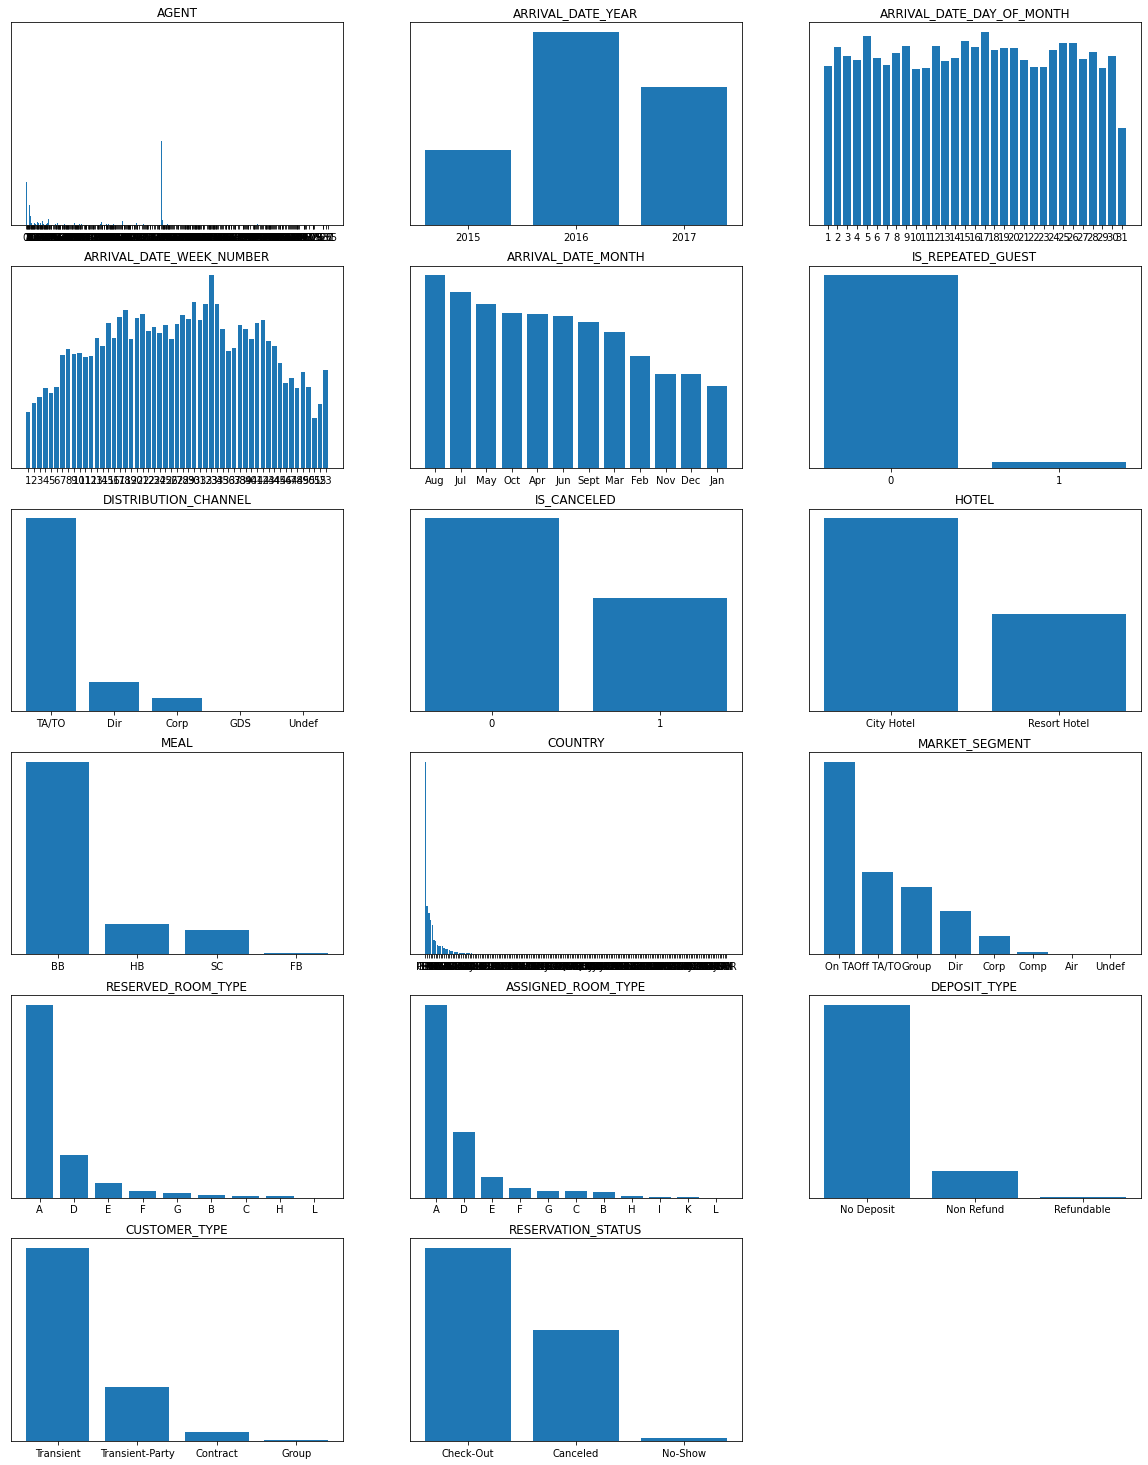

In [19]:
month_abv = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug', 'September': 'Sept', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
data = data.replace(month_abv)

market_seg = {'Aviation': 'Air', 'Corporate': 'Corp', 'Direct': 'Dir', 'Undefined': 'Undef', 'Groups': 'Group', 'Offline TA/TO': 'Off TA/TO', 'Online TA': 'On TA', 'Complementary': 'Comp'}
data = data.replace(market_seg)

fig, ax = plt.subplots(figsize=(16, 20))
ax.axis('off')
fig.tight_layout()
for idx, i in enumerate(cats):
    labels = list(data[i].value_counts().index)
    values = list(data[i].value_counts())
    fig.add_subplot(6,3,idx+1)
    plt.bar(labels, values)
    plt.xticks(labels)
    plt.yticks([])
    plt.title(i.upper())
    
# variable name above plot

From the above bar plots of the categorical variables, we can see that the three summer months of August, July, and May had the highest number of hotel bookings. We can see that most guests only had a breakfast (BB) meal type booked. The TA/TO market segment appears to be the most prevalent.  Moreover, the most popular room type reserved (and assigned) was room A.  Most guests did not provide a desposit and were labeled as transient (as opposed to contract or group) customer types. Furthermore, the target variables hotel and is_cancelled that we will attempt to perform classification modeling techniques on do not appear to be too unbalanced.

__Look at the top ten countries hotel guests came from:__

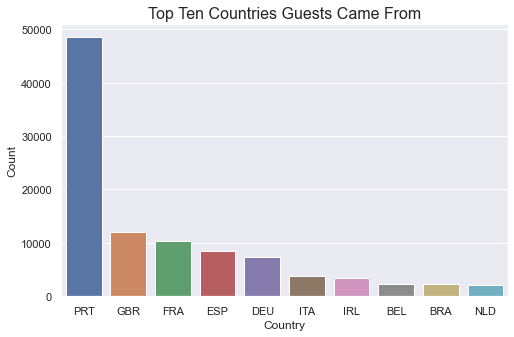

In [20]:
country = data.country.value_counts()

countries = pd.DataFrame({'country':country.index, 'count':country.values})
countries = countries.head(10)

plt.figure(figsize = (8,5))
sns.set(style = 'darkgrid')
sns.barplot(x = 'country', y = 'count', data = countries)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Top Ten Countries Guests Came From', fontsize = 16)
plt.show()

The vast majority of hotel guests came from Portugal.  This intuitively makes sense, as both of the hotels in this data set are located in Portugal.  A large number of guests also came from Great Britain, France, Spain, and Germany (other European countries).

#### Boxplots for categorical variables showing differences with respect to average daily rate (adr):

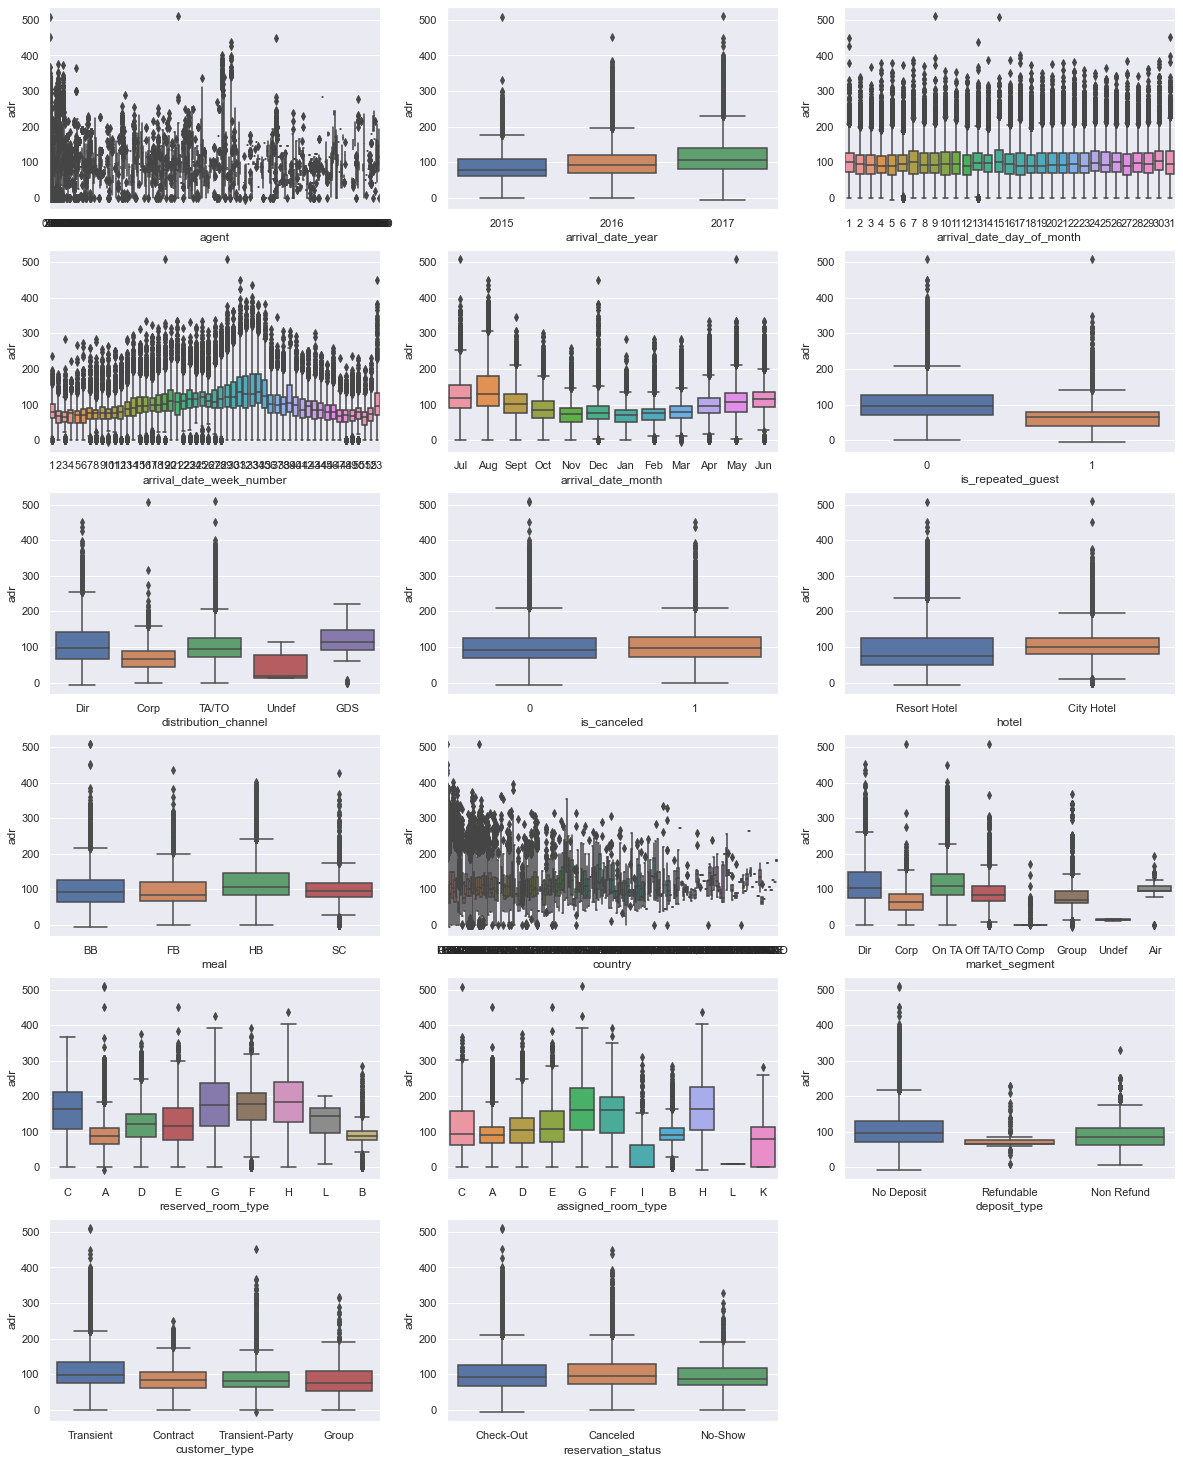

In [21]:
fig, ax = plt.subplots(figsize=(16, 20))
ax.axis('off')
fig.tight_layout()
for idx, i in enumerate(cats):
    series = data.groupby([i])['adr']
    fig.add_subplot(6,3,idx+1)
    sns.boxplot(y=data['adr'], x=data[i])

# variable name below plot

- We can see that some categorical variables have a relationship to the average daily rate, adr (arrival_date_week/month, is_repeated_guest, distribution_channel, market_segment, reserved_room_type, assigned_room_type) because the 'box' (Q1, Q2, Q3) vary based on category for that variable
- The other variables do not show large differences with respect to average daily rate

- Can see that there are very few samples for assigned_room_type = L and market_segment = Undef (Undefined)

In [22]:
data.assigned_room_type.value_counts()

A    74019
D    25309
E     7798
F     3751
G     2549
C     2370
B     2154
H      712
I      359
K      187
L        1
Name: assigned_room_type, dtype: int64

In [23]:
data.market_segment.value_counts()

On TA        56408
Off TA/TO    24181
Group        19791
Dir          12582
Corp          5282
Comp           728
Air            235
Undef            2
Name: market_segment, dtype: int64

- Actually only 1 sample for assigned_room_type = L and 2 samples for market_segment = Undef so we will remove them from the data

In [24]:
data[(data['assigned_room_type']== 'L') | (data['market_segment']== 'Undef')] # find index for those samples

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
14381,Resort Hotel,1,0,2015,Jul,29,17,0,1,2,0.0,0,BB,PRT,Dir,Dir,0,1,2,L,L,0,No Deposit,0.0,0,Transient,8.0,0,0,Canceled
40600,City Hotel,1,2,2015,Aug,32,3,1,0,2,0.0,0,BB,PRT,Undef,Undef,0,0,0,B,B,0,No Deposit,0.0,0,Transient-Party,12.0,0,1,Canceled
40679,City Hotel,1,1,2015,Aug,32,5,0,2,3,0.0,0,BB,PRT,Undef,Undef,0,0,0,B,B,0,No Deposit,0.0,0,Transient-Party,18.0,0,2,Canceled


In [25]:
data.drop([14381, 40600, 40679], axis=0, inplace=True) # remove those samples

### Exploring the agent variable by average adr:

In [26]:
agent_adr = data.groupby(['agent'])['adr'].mean().sort_values() # mean adr by agent
agent_adr

agent
302.0      0.000000
45.0       2.633333
367.0     21.000000
321.0     22.000000
375.0     29.887500
            ...    
508.0    190.691667
433.0    193.600000
70.0     211.330000
426.0    238.723333
404.0    284.200000
Name: adr, Length: 334, dtype: float64

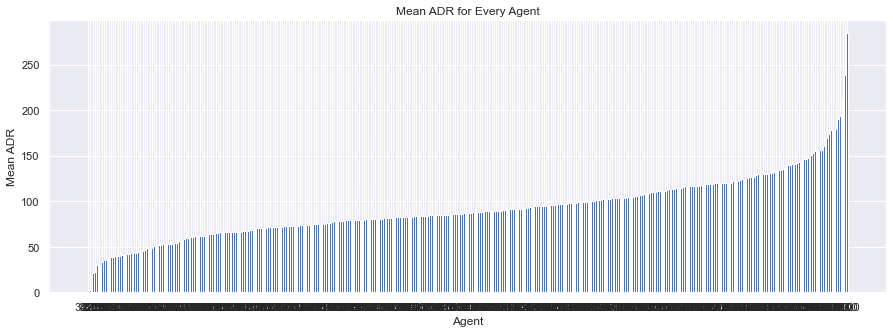

In [27]:
# bar chart of mean adr by agent
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar([str(i) for i in list(agent_adr.index)], list(agent_adr))
plt.xlabel('Agent')
plt.ylabel('Mean ADR')
plt.title('Mean ADR for Every Agent')
plt.show()

In [28]:
agent_bookings = data.agent.value_counts(normalize=True)*100 # percentage of bookings for each agent
agent_bookings

9.0      26.778853
0.0      13.654514
240.0    11.678942
1.0       6.029059
14.0      3.047665
           ...    
117.0     0.000839
294.0     0.000839
352.0     0.000839
158.0     0.000839
472.0     0.000839
Name: agent, Length: 334, dtype: float64

In [29]:
(agent_bookings[agent_bookings<0.001]).shape # There are 50 agents with only 1 booking

(50,)

In [30]:
print(agent_bookings.iloc[:166].sum()) # 166 agents (out of 334) booked 99% of stays
agents_reduced = agent_bookings.iloc[:166] # create series with only those 166 agents
agents_reduced

99.01682801201282


9.0      26.778853
0.0      13.654514
240.0    11.678942
1.0       6.029059
14.0      3.047665
           ...    
205.0     0.022650
323.0     0.020972
310.0     0.020972
153.0     0.020972
23.0      0.020972
Name: agent, Length: 166, dtype: float64

In [31]:
agent_adr_red = agent_adr[agents_reduced.index].sort_values() # filter 166 agents into new mean_adr variable
agent_adr_red 

45.0       2.633333
375.0     29.887500
332.0     42.381818
334.0     42.611071
185.0     42.833077
            ...    
149.0    132.457143
250.0    132.605314
235.0    140.000000
181.0    141.596949
254.0    154.581379
Name: adr, Length: 166, dtype: float64

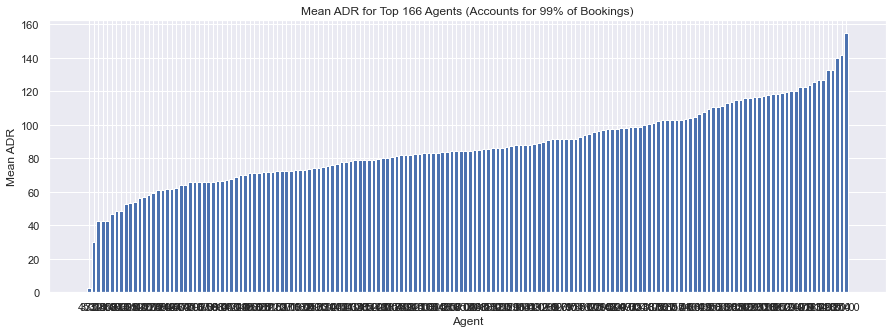

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar([str(i) for i in list(agent_adr_red.index)], list(agent_adr_red))
plt.xlabel('Agent')
plt.ylabel('Mean ADR')
plt.title('Mean ADR for Top 166 Agents (Accounts for 99% of Bookings)')
plt.show()

## Convert categorical variables to numeric values and normalize the data:

__Convert categorical variables to numeric values:__

In [33]:
data = pd.DataFrame(data)

hotel_num = {'Resort Hotel': 0, 'City Hotel': 1}
data = data.replace(hotel_num)

month_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
data = data.replace(month_num)

meal_num = {'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3}
data = data.replace(meal_num)

market_num = {'Air': 0, 'Corp': 1, 'Dir': 2, 'Undef': 3, 'Group': 4, 'GDS': 4, 'TA/TO': 5, 'Off TA/TO': 5, 'On TA': 6, 'Comp': 7}
data = data.replace(market_num)

room_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 9, 'K': 10, 'L': 8}
data = data.replace(room_num)

deposit_num = {'No Deposit': 0, 'Non Refund': 1, 'Refundable': 2}
data = data.replace(deposit_num)

customer_num = {'Contract': 0, 'Group': 1, 'Transient': 2, 'Transient-Party': 3}
data = data.replace(customer_num)

reservation_num = {'Canceled': 0, 'Check-Out': 1, 'No-Show': 2}
data = data.replace(reservation_num)

country_oe = OrdinalEncoder()
data['country'] = country_oe.fit_transform(np.array(data['country']).reshape(-1,1))
# countries = {}
# count = 0
# # to convert country variable to numeric values
# for row in data.itertuples():
#     if row.country in countries:
#         pass
#     else:
#         countries[row.country] = count
#         count += 1

# data = data.replace(countries)

In [34]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,0,0,342,2015,7,27,1,0,0,2,0.0,0,0,135.0,2,2,0,0,0,2,2,3,0,0.0,0,2,0.0,0,0,1
1,0,0,737,2015,7,27,1,0,0,2,0.0,0,0,135.0,2,2,0,0,0,2,2,4,0,0.0,0,2,0.0,0,0,1
2,0,0,7,2015,7,27,1,0,1,1,0.0,0,0,59.0,2,2,0,0,0,0,2,0,0,0.0,0,2,75.0,0,0,1
3,0,0,13,2015,7,27,1,0,1,1,0.0,0,0,59.0,1,1,0,0,0,0,0,0,0,304.0,0,2,75.0,0,0,1
4,0,0,14,2015,7,27,1,0,2,2,0.0,0,0,59.0,6,5,0,0,0,0,0,0,0,240.0,0,2,98.0,0,1,1


__Normalize data:__

In [35]:
min_max_scaler = preprocessing.MinMaxScaler().fit(data)
data_norm = min_max_scaler.transform(data) # min-max normalization to scale all variables between 0 & 1

In [36]:
data_norm = pd.DataFrame(data_norm)
data_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.464043,0.0,0.545455,0.5,0.0,0.0,0.00,0.036364,0.0,0.0,0.0,0.762712,0.285714,0.25,0.0,0.0,0.0,0.25,0.2,0.166667,0.0,0.000000,0.0,0.5,0.012355,0.0,0.0,0.5
1,0.0,0.0,1.000000,0.0,0.545455,0.5,0.0,0.0,0.00,0.036364,0.0,0.0,0.0,0.762712,0.285714,0.25,0.0,0.0,0.0,0.25,0.2,0.222222,0.0,0.000000,0.0,0.5,0.012355,0.0,0.0,0.5
2,0.0,0.0,0.009498,0.0,0.545455,0.5,0.0,0.0,0.02,0.018182,0.0,0.0,0.0,0.333333,0.285714,0.25,0.0,0.0,0.0,0.00,0.2,0.000000,0.0,0.000000,0.0,0.5,0.157597,0.0,0.0,0.5
3,0.0,0.0,0.017639,0.0,0.545455,0.5,0.0,0.0,0.02,0.018182,0.0,0.0,0.0,0.333333,0.142857,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.568224,0.0,0.5,0.157597,0.0,0.0,0.5
4,0.0,0.0,0.018996,0.0,0.545455,0.5,0.0,0.0,0.04,0.036364,0.0,0.0,0.0,0.333333,0.857143,1.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.448598,0.0,0.5,0.202138,0.0,0.2,0.5


## Perform Classification (KNN, Decision Tree, Multinomial Naive Bayes & SVM) using Hotel variable as the target: 

__Isolate target variable (hotel) and split into training/test sets:__

In [37]:
target = data_norm[0]
matrix = data_norm.iloc[:, 1:30]

In [38]:
train, test, target_train, target_test = train_test_split(matrix, target, test_size=0.2, random_state=33)  # using an 80/20 split

In [39]:
train.shape

(95364, 29)

In [40]:
test.shape

(23842, 29)

### KNN (target: hotel):

__Perform classification using k-nearest neighbors and utilizing a grid search to optimize the value of k:__

In [ ]:
clf = neighbors.KNeighborsClassifier()                 # initialize knn classifier
parameters = {'n_neighbors': [1,3,5,7,9]}              # parameters for grid search (values of k=1, k=3, k=5, k=7, k=9)
gs = GridSearchCV(clf, parameters, verbose=1, cv=5)    # initialize grid search w/ specified parameters & 5-fold cross-validation

In [ ]:
#gs.fit(train, target_train)   # perform grid search on training data 

In [ ]:
"""
for (i, j) in gs.best_params_.items():
    print ("The optimal value of", i, "is:", j)
print()
print("The best cross-validation accuracy on the training data was: {}".format(gs.best_score_))
"""

__Using the best value of k (k=1), apply model to the set aside test data:__

In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1)  # initialize with k=1

clf.fit(train, target_train)                         # fit on training data

pred_test_target = clf.predict(test)                 # predict classes of test set

print(classification_report(target_test, pred_test_target))  # print classification report

The accuracy for this knn classifier on the test data was 96%.  That is, the model was able to correctly predict whether the observation was a city hotel or a resort hotel in 96% of the total test cases. The above classification report also shows the precision, recall, and F1-scores.

__Visualize results with confusion matrix:__

In [ ]:
knncm = confusion_matrix(target_test, pred_test_target)

ax= plt.subplot()
sns.heatmap(knncm, annot=True, fmt='d', cmap='Blues', ax = ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['resort', 'city']); ax.yaxis.set_ticklabels(['resort', 'city']);

There are more predictions for city hotels than resort hotels because this data set contains more observations belonging to the city hotel class.

### Decision Tree (target: hotel):

__Perform classification using decision tree and a grid search to optimize the impurity measure and minimum number of samples per split:__

In [41]:
clf2 = tree.DecisionTreeClassifier()                                                       # initialize dt classifier
parameters = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2,4,8,15,30,50,100]} # grid search parameters for criterion & min_samples_split
gs2 = GridSearchCV(clf2, parameters, verbose=1, cv=5)  # initialize grid search w/ parameters & 5-fold cv

In [42]:
gs2.fit(train, target_train)   # perform grid search on training data

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4, 8, 15, 30, 50, 100]},
             verbose=1)

In [43]:
for (i, j) in gs2.best_params_.items():
    print ("The optimal value of", i, "is:", j)
print()
print("The best cross-validation accuracy on the training data was: {}".format(gs2.best_score_))

The optimal value of criterion is: entropy
The optimal value of min_samples_split is: 2

The best cross-validation accuracy on the training data was: 0.9801916897705285


__Using the optimal parameters (criterion='entropy' and min_samples_split=2), apply model to set aside test data:__

In [44]:
clf2 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2)  # initialize dt classifier with entropy impurity measure and min samples per split = 2

clf2.fit(train, target_train)                         # fit on training data

pred_test_target = clf2.predict(test)                 # predict classes of test set

print(classification_report(target_test, pred_test_target))  # print classification report

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      7996
         1.0       0.99      0.99      0.99     15846

    accuracy                           0.98     23842
   macro avg       0.98      0.98      0.98     23842
weighted avg       0.98      0.98      0.98     23842



The accuracy for this decision tree classifier on the test data was 98%. It is accurately predicting the hotel class 98% of the time, and is outperforming the previous knn classifier.  This is a very good model.

__Visualize results with confusion matrix:__

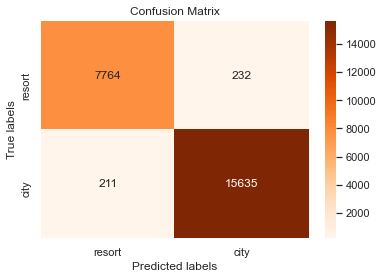

In [45]:
dtcm = confusion_matrix(target_test, pred_test_target)

ax= plt.subplot()
sns.heatmap(dtcm, annot=True, fmt='d', cmap='Oranges', ax = ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['resort', 'city']); ax.yaxis.set_ticklabels(['resort', 'city']);

This classifier mislabelled less than 500 observations out of a total of 23,842 test cases.

### Multinomial Naive Bayes (target: hotel):

__Perform classification using multinomial naive bayes and a grid search to optimize the parameters:__

In [ ]:
clf3 = MultinomialNB()                                            # initialize mnb classifier
alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4]           # alphas to perform grid search on
parameters = {'alpha': alphas, 'fit_prior' : [True, False]}       # parameters for grid search
gs3 = GridSearchCV(clf3, parameters, verbose=1, cv=5)             # grid search using 5-fold cv

In [ ]:
gs3.fit(train, target_train)     # perform grid search

In [ ]:
for (i, j) in gs3.best_params_.items():
    print ("The optimal value of", i, "is:", j)
print()
print("The best cross-validation accuracy on the training data was: {}".format(gs3.best_score_))

__Using the optimal parameters (alpha = .0001 and fit_prior = True), apply model to set aside test data:__

In [ ]:
clf3 = MultinomialNB(alpha=.0001, fit_prior=True)  # initialize mnb classifier with smoothing parameter alpha = .1  & allow it to learn prior class probabilities

clf3.fit(train, target_train)                   # fit on training data

pred_test_target = clf3.predict(test)           # predict classes of test set

print(classification_report(target_test, pred_test_target))  # print classification report

This multinomial naive bayes classifier is correctly predicting the hotel class only 79% of the time.  The results are not as good as the knn classifier or the decision tree classifier.  It is a much poorer model than the previous two.

__Visualize results with confusion matrix:__

In [ ]:
mnbcm = confusion_matrix(target_test, pred_test_target)

ax= plt.subplot()
sns.heatmap(mnbcm, annot=True, fmt='d', cmap='Greens', ax = ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['resort', 'city']); ax.yaxis.set_ticklabels(['resort', 'city']);

This classifier incorrectly labelled far too many observations as city hotel instead of resort hotel.

### SVM (target: hotel):

__Perform classification using support vector classifier and a grid search to optimize the C, gamma, and kernel parameters:__

In [ ]:
clf4 = SVC(class_weight='balanced')                    # initialize svm classifier w/ balanced class weights

# grid search parameters:
parameters = {'gamma': [0.1, .25, .4, .5, .7], 'C': [20, 40, 50, 75, 100], 'kernel': ['rbf', 'poly']}

gs4 = GridSearchCV(clf4, parameters, verbose=1, cv=3)   # initialize grid search w/ 3-fold cv

__Take random sample of 25% of the data to perform a grid search on (to speed up grid search process):__

In [ ]:
sample = data_norm.sample(frac =.25)     # random sample
target_sample = sample[0]                # isolate target variable (hotel)
matrix_sample = sample.iloc[:, 1:30]     # rest of sample data for grid search

__Grid search:__

In [ ]:
#gs4.fit(matrix_sample, target_sample)   # perform grid search on sample

In [ ]:
"""
for (i, j) in gs4.best_params_.items():
    print ("The optimal value of", i, "is:", j)
print()
print("The best cross-validation accuracy on the sample data was: {}".format(gs4.best_score_))
"""

__Using the optimal C, gamma, and kernel parameters found using a grid search on the smaller sample of the data, apply model (fit on the training data) to the set aside test data:__

In [ ]:
clf4 = SVC(kernel='rbf', gamma =.7, C=50, class_weight='balanced')  # initialize svm classifier with optimal parameters

clf4.fit(train, target_train)                   # fit on training data

pred_test_target = clf4.predict(test)           # predict classes of test set

print(classification_report(target_test, pred_test_target))  # print classification report

This support vector classifier is correctly predicting the hotel class on the test data in 97% of the test cases.  Thus, it performed better than the multinomial naive bayes classifier, and very similarly to the knn and decision tree classifiers.

__Visualize results with confusion matrix:__

In [ ]:
svmcm = confusion_matrix(target_test, pred_test_target)

ax= plt.subplot()
sns.heatmap(svmcm, annot=True, fmt='d', cmap='Reds', ax = ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['resort', 'city']); ax.yaxis.set_ticklabels(['resort', 'city']);

### Compare all four models using ROC curves:

In [ ]:
# Code adapted from ensemble-classification1.ipynb:
"""
models = [
{
    'label': 'KNN',
    'model': neighbors.KNeighborsClassifier(n_neighbors=1),
},
{
    'label': 'Decision Tree',
    'model': tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2),
},
{
    'label': 'Multinomial NB',
    'model': MultinomialNB(alpha=.1, fit_prior=True),
},
{
    'label': 'SVM',
    'model': SVC(kernel='rbf', gamma = .7, C= 50, class_weight='balanced', probability=True),
}
]
# below for loop iterates through models list
for m in models:
    model = m['model']              # select the model
    model.fit(train, target_train)  # train the model
    y_pred=model.predict(test)      # predict the test data
# compute false postive rate, and true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(target_test, model.predict_proba(test)[:,1])
# calculate AUC to display on the plot
    auc = metrics.roc_auc_score(target_test, model.predict(test))
# plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# custom settings for the plot 
plt.plot([0, 1], [0, 1],'k--',label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")  # legend location
plt.show()   # display
"""

The above graph shows the performance for each of the four models (KNN, Decision Tree, Multinomial Naive Bayes, & SVM) over a range of probability thresholds.  The KNN, decision tree, and SVM classifiers all performed very well, with high respective AUC's (area under the curve).  The multinomial naive bayes classifier on the other hand, has a relatively low AUC.  For this data set, I would select the decision tree classifier as the best model for predicting the hotel class, as it displayed the highest overall accuracy (98%) and has the best AUC. 

## Perform Classification (KNN, Decision Tree, Multinomial Naive Bayes & SVM) using is_canceled as the target variable: 

__Isolate target variable (is_canceled) and split into training/test sets:__

In [27]:
# set up our target variable and data matrix
y = data['is_canceled']
X = data.drop(columns=['is_canceled', 'reservation_status'])

In [67]:
# min-max normalize the data to a 0-1 scale
X_norm = preprocessing.MinMaxScaler().fit_transform(X)

In [68]:
# split the data into training and testing groups
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=33)

### Multinomial Naive Bayes (target: is_canceled):
Start by using Navie Bayes as this algorithm is a good baseline predictor for which the other algorithms can be compared to.

__Perform classification using multinomial naive bayes and a grid search to optimize the parameters:__

In [69]:
nb = MultinomialNB()
alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
parameters = {'alpha': alphas, 'fit_prior' : [True, False]}
nb_cv = GridSearchCV(nb, parameters, verbose=1, cv=5)

In [70]:
nb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4],
                         'fit_prior': [True, False]},
             verbose=1)

In [71]:
nb_cv.best_params_

{'alpha': 0.0001, 'fit_prior': True}

In [72]:
nb_cv.best_score_

0.7508283923134252

__Using the optimal parameters, apply model to set aside test data:__

In [73]:
nb.alpha = nb_cv.best_params_['alpha']
nb.fit_prior = nb_cv.best_params_['fit_prior']
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.0001)

In [74]:
# get the predictions for our test data
nb_preds = nb.predict(X_test)

In [76]:
# print classification report to get metrics
print(classification_report(y_test, nb_preds))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     14956
           1       0.98      0.33      0.50      8886

    accuracy                           0.75     23842
   macro avg       0.85      0.66      0.66     23842
weighted avg       0.81      0.75      0.71     23842



__Visualize results with confusion matrix:__

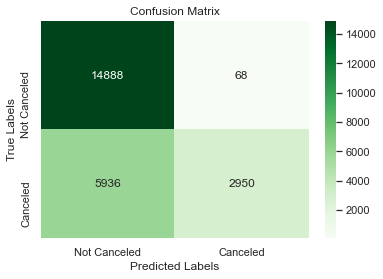

In [78]:
nb_cm = confusion_matrix(y_test, nb_preds)

ax = plt.subplot()
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens', ax=ax); 

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled']); ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled']);

This model is not great at predicting hotel reservations that have indeed been canceled. In fact, for canceled reservations, it often predicts that the reservation has not been canceled more often than it has been canceled. Using Naive Bayes as our baseline model, we hope to improve on the 75% accuracy rate.

### Decision Tree (target: is_canceled):

__Perform classification using decision tree and a grid search to optimize the impurity measure and minimum number of samples per split:__

In [79]:
dt = tree.DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2,4,8,15,30,50,100]}
dt_cv = GridSearchCV(dt, parameters, verbose=1, cv=5)

In [80]:
# fit the training data to the grid search
dt_cv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4, 8, 15, 30, 50, 100]},
             verbose=1)

In [81]:
dt_cv.best_params_

{'criterion': 'entropy', 'min_samples_split': 50}

In [82]:
dt_cv.best_score_

0.8591607110590994

In [83]:
# set the parameters for our model, and fit the model
dt.criterion = dt_cv.best_params_['criterion']
dt.min_samples_split = dt_cv.best_params_['min_samples_split']
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=50)

In [84]:
# get the predictions for our test data
dt_preds = dt.predict(X_test)

In [85]:
# print out classification report
print(classification_report(y_test, dt_preds))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14956
           1       0.83      0.79      0.81      8886

    accuracy                           0.86     23842
   macro avg       0.85      0.85      0.85     23842
weighted avg       0.86      0.86      0.86     23842



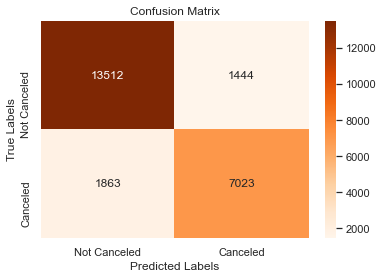

In [87]:
dt_cm = confusion_matrix(y_test, dt_preds)

ax= plt.subplot()
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Oranges', ax = ax); 

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled']); ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled']);

Our accuracy score on the training data was about 86%. This definitely is an improvement over our Naive Bayes model. We also had about an 86% accuracy on our training data meaningour model is neither underfit nor overfit.

## Regression (target: ADR)

In [86]:
lr_data = pd.DataFrame(data_norm)
lr_data.columns = data.columns
adr = data_norm['adr']
train_data = data_norm.drop(['adr', 'arrival_date_year', 'country', 'agent', 'assigned_room_type', 'reservation_status'], axis=1)

In [87]:
train, test, train_target, test_target = train_test_split(train_data, adr, test_size=0.2, random_state=99)

In [88]:
lr = LinearRegression()
params = {'fit_intercept':[True, False]}
lr_clf = GridSearchCV(lr, params, verbose=1, cv=5).fit(train, train_target)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [89]:
lr_clf.best_params_

{'fit_intercept': True}

In [90]:
lr_best = LinearRegression(fit_intercept=True).fit(train, train_target)

Since input data is normalized, coefficents can be used to determine relative impact of each independent variable

In [91]:
coefs = pd.Series(lr_best.coef_, index=train_data.columns).sort_values() 
coefs

arrival_date_week_number         -1.595858
previous_cancellations           -0.087491
lead_time                        -0.073115
previous_bookings_not_canceled   -0.045082
is_repeated_guest                -0.042969
customer_type                    -0.003280
market_segment                   -0.002833
deposit_type                      0.001027
days_in_waiting_list              0.002957
distribution_channel              0.003784
stays_in_weekend_nights           0.005743
is_canceled                       0.016279
meal                              0.026676
babies                            0.037377
hotel                             0.040906
booking_changes                   0.054196
total_of_special_requests         0.056657
stays_in_week_nights              0.079496
arrival_date_day_of_month         0.140248
reserved_room_type                0.146330
required_car_parking_spaces       0.167895
children                          0.460624
adults                            1.130865
arrival_dat

- arrival_date_week_number has the largest negative impact on adr 
- arrival_date_month has the largest positive impact

In [92]:
lr_best_preds = lr_best.predict(test)

In [93]:
r2_score(test_target, lr_best_preds)

0.3522936961616042

In [94]:
mean_absolute_error(test_target, lr_best_preds)

0.05428637231299854

- R-squared of 0.35 is not sufficient to make this a useful model
- Let's create dummie variables for categorical vars

In [95]:
hotel = pd.get_dummies(train_data['hotel'], prefix='hotel', drop_first=True)
dist_channel = pd.get_dummies(train_data['distribution_channel'], prefix='dist_channel', drop_first=True)
meal = pd.get_dummies(train_data['meal'], prefix='meal', drop_first=True)
mark_seg = pd.get_dummies(train_data['market_segment'], prefix='mark_seg', drop_first=True)
reserved_room = pd.get_dummies(train_data['reserved_room_type'], prefix='reserved_room', drop_first=True)
deposit = pd.get_dummies(train_data['deposit_type'], prefix='deposit', drop_first=True)
cust_type = pd.get_dummies(train_data['customer_type'], prefix='cust', drop_first=True)
dummie_list = [hotel, dist_channel, meal, mark_seg, reserved_room, deposit, cust_type]

- remove original data from data

In [96]:
train_data_red = train_data.drop(['hotel', 'distribution_channel', 'meal', 'market_segment', 'reserved_room_type', 'deposit_type', 'customer_type'], axis=1)

- join dummy variables to other variables

In [97]:
train_data_dums = train_data_red.join(dummie_list)

In [98]:
train, test, train_target, test_target = train_test_split(train_data_dums, adr, test_size=0.2, random_state=99)

In [99]:
lr = LinearRegression()
params = {'fit_intercept':[True, False]}
lr_clf_dums = GridSearchCV(lr, params, verbose=1, cv=5).fit(train, train_target)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [100]:
lr_clf_dums.best_params_

{'fit_intercept': True}

In [101]:
lr_dums = LinearRegression(fit_intercept=True).fit(train, train_target)

Since input data is normalized, coefficents can be used to determine relative impact of each independent variable

In [102]:
coefs = pd.Series(lr_dums.coef_, index=train_data_dums.columns).sort_values() 
coefs

arrival_date_week_number         -1.552352
mark_seg_1.0                     -0.201067
previous_cancellations           -0.097977
dist_channel_0.5                 -0.086374
lead_time                        -0.057650
mark_seg_0.5714285714285714      -0.039549
reserved_room_0.125              -0.037754
mark_seg_0.14285714285714285     -0.030147
mark_seg_0.7142857142857142      -0.029604
is_repeated_guest                -0.029422
meal_1.0                         -0.012306
cust_1.0                         -0.006167
dist_channel_1.0                 -0.005102
dist_channel_0.25                -0.001435
stays_in_weekend_nights           0.005580
is_canceled                       0.009446
mark_seg_0.2857142857142857       0.010144
mark_seg_0.8571428571428571       0.015438
cust_0.75                         0.017262
cust_0.5                          0.017747
days_in_waiting_list              0.019335
deposit_0.5                       0.020794
total_of_special_requests         0.026883
deposit_1.0

- arrival_date_week_number still has the largest negative impact on adr 
- arrival_date_month still has the largest positive impact

In [103]:
lr_dums_preds = lr_dums.predict(test)

In [104]:
r2_score(test_target, lr_dums_preds)

0.43837330137281805

In [105]:
mean_absolute_error(test_target, lr_dums_preds)

0.05019987859147541

- R-squared improved from 35% to 44% (25% increase) but this is still not very useful as a model
- Let's try removing non-dummy dependent variables with coefficients between -0.2 and 0.2

In [106]:
drop_vars = ['stays_in_weekend_nights', 'is_canceled', 'days_in_waiting_list']
train_data_dums2 = train_data_dums.drop(drop_vars, axis=1)

In [107]:
train, test, train_target, test_target = train_test_split(train_data_dums2, adr, test_size=0.2, random_state=99)

In [108]:
lr = LinearRegression()
params = {'fit_intercept':[True, False]}
lr_clf_dums2 = GridSearchCV(lr, params, verbose=1, cv=5).fit(train, train_target)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [109]:
lr_clf_dums2.best_params_

{'fit_intercept': True}

In [110]:
lr_dums2 = LinearRegression(fit_intercept=True).fit(train, train_target)

Since input data is normalized, coefficents can be used to determine relative impact of each independent variable

In [111]:
coefs = pd.Series(lr_dums2.coef_, index=train_data_dums2.columns).sort_values()

- arrival_date_week_number still has the largest negative impact on adr 
- arrival_date_month still has the largest positive impact

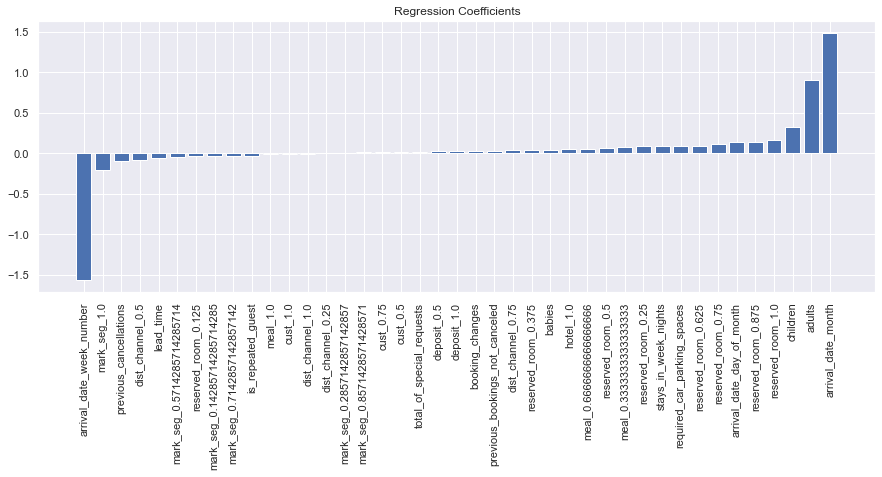

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(coefs.index, list(coefs))
plt.xticks(rotation=90)
plt.title('Regression Coefficients')
plt.show()

In [113]:
lr_dums2_preds = lr_dums2.predict(test)

In [114]:
r2_score(test_target, lr_dums2_preds)

0.43649060373294923

In [115]:
mean_absolute_error(test_target, lr_dums2_preds)

0.05025877128145915

- Removeing those vars had no impact on model performance

## Gradient Descent (target: adr)

- Using data with dummy variables

In [116]:
train_data_dums = train_data_red.join(dummie_list)

In [117]:
train, test, train_target, test_target = train_test_split(train_data_dums, adr, test_size=0.2, random_state=99)

In [118]:
sgd = SGDRegressor()
params = {'penalty':['l1', 'l2'], 'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'random_state':[99]}
sgd_clf = GridSearchCV(sgd, params, scoring='r2', verbose=1, cv=5).fit(train, train_target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   14.9s finished


In [119]:
sgd_clf.best_params_

{'alpha': 1e-05, 'penalty': 'l2', 'random_state': 99}

In [120]:
sgd1 = SGDRegressor(alpha=0.00001, penalty='l2', random_state=99).fit(train, train_target)

In [121]:
coefs = pd.Series(sgd1.coef_, index=train_data_dums.columns).sort_values() # coefficients

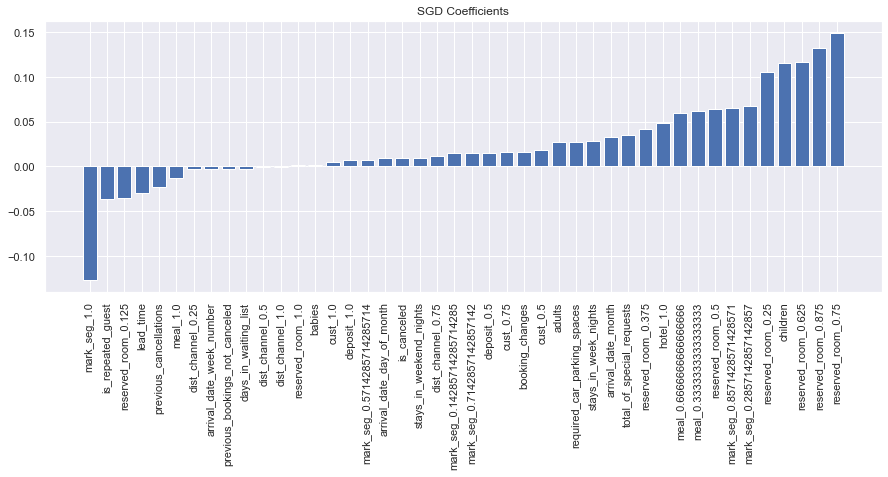

In [122]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(coefs.index, list(coefs))
plt.xticks(rotation=90)
plt.title('SGD Coefficients')
plt.show()

Comparing SGD to multiple regression: SDG distributes weights of variables more evenly than MR where most influence on the dependent variable (adr) is concentrated on just a few variables. In either case, R-squared is less than 0.5 meaning that less than 50% of the variance in average daily rate can be explained by the models. 

In [123]:
sgd1_preds = sgd1.predict(test)

In [124]:
metrics.r2_score(test_target, sgd1_preds)

0.40553894090236287

In [125]:
mean_absolute_error(test_target, sgd1_preds)

0.05214315570321676

In [126]:
sgd1.n_iter_ # only 6 iterations before (probably local) minimum reached

6

In [127]:
sgd = SGDRegressor()
params = {'penalty':['elasticnet'], 'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'l1_ratio':np.arange(0.05, 1, 0.5), 'random_state':[99]}
sgd_clf = GridSearchCV(sgd, params, scoring='r2', verbose=1, cv=5).fit(train, train_target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   16.9s finished


In [128]:
sgd_clf.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.05, 'penalty': 'elasticnet', 'random_state': 99}

In [129]:
sgd2 = SGDRegressor(penalty='elasticnet', alpha=0.00001, l1_ratio=0.05, random_state=99).fit(train, train_target)

In [130]:
sgd2_preds = sgd2.predict(test)

In [131]:
metrics.r2_score(test_target, sgd2_preds)

0.405524550779956

In [132]:
mean_absolute_error(test_target, sgd2_preds)

0.052149560772385715

- no difference between elasticnet and L2 penalties